#Exercício em Python - Tema 1 - Ajuste de Equações de Chuva Máxima

## 1. Importar bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from decimal import Decimal

### Read files - Google Drive

In [ ]:
#Conexao com o Google Drive. Pode-se conectar com outras plataformas ou usar dados locais
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##%cd /content/drive/Shareddrives/Projeto Exercícios CABra/Exercícios/Exercicios_Mudancas_Climaticas/Dados
%cd /content/drive/MyDrive/CABra_climate_daily_series/climate_daily

/content/drive/MyDrive/CABra_climate_daily_series/climate_daily


## Obter a série de dados de precipitação diária

In [ ]:
#Colocar o id da bacia hidrográficas do CABra
id_bacia = 462 #

#Colocar o caminho (link) dos dados
caminho = "/content/drive/MyDrive/CABra_climate_daily_series/climate_daily/ens/"+"CABra_"+str(id_bacia)+"_climate_"+"ENS"+".txt"

#Lendo as informacoes
precipitacao_dados = pd.read_csv(caminho,
                                 encoding='latin',
                                 delimiter='\t',
                                 skiprows=[0,1,2,3,4,5,6,7,8,9,10,11,12,14]
                  )


data = []
for i in range(len(precipitacao_dados)):
  data.append(datetime.strptime(str(precipitacao_dados[' Year'][i])+"/"+str(precipitacao_dados[' Month'][i])+"/"+str(precipitacao_dados['   Day'][i]),"%Y/%m/%d").date())

precipitacao_dados['data'] = data


precipitacao_dados = precipitacao_dados.rename(columns={'     PREC': 'PREC'})
precipitacao_dados = precipitacao_dados.rename(columns={' Year': 'Year'})
precipitacao_dados = precipitacao_dados.rename(columns={' Month': 'Month'})
precipitacao_dados = precipitacao_dados.rename(columns={'   Day': 'Day'})


### Calcular precipitações mensais médias

Text(0, 0.5, 'Mean Monthly Precipitation')

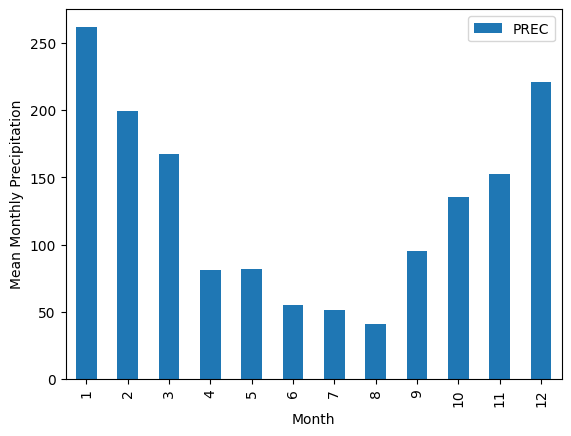

In [ ]:


# Group data by year and month, then calculate the mean monthly precipitation
monthly_precipitation = precipitacao_dados.groupby(['Year', 'Month'])['PREC'].sum().reset_index()
monthly_precipitation = monthly_precipitation.groupby(['Month'])['PREC'].mean().reset_index()

# Rename the columns

# Display the result
monthly_precipitation.plot(x='Month', y='PREC', kind='bar')
plt.xlabel('Month')
plt.ylabel('Mean Monthly Precipitation')

### Determinar o início do ano hidrológico

<Figure size 1000x600 with 0 Axes>

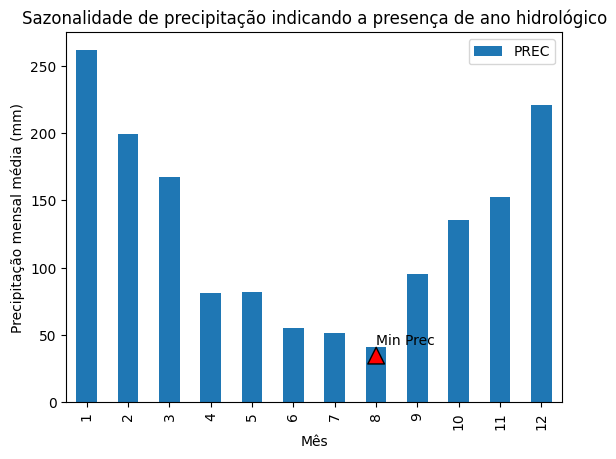

In [ ]:
# Find the month with the lowest precipitation
min_precipitation_month = monthly_precipitation['Month'][monthly_precipitation['PREC'].idxmin()]-1

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
monthly_precipitation.plot(x='Month', y='PREC', kind='bar')
plt.xlabel('Mês')
plt.ylabel('Precipitação mensal média (mm)')

# Add the red arrow
plt.annotate('Min Prec', xy=(min_precipitation_month, monthly_precipitation['PREC'].min()),
             xytext=(min_precipitation_month, monthly_precipitation['PREC'].min() + 2), # Adjust vertical offset
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.title('Sazonalidade de precipitação indicando a presença de ano hidrológico')

plt.show()

### Ajustar o ano hidrológico

In [ ]:
ano_hidrologico_inicio = 8

# Define a function to adjust the dates according to the hydrological year
def adjust_hydrological_year(df):
    # Create a copy to avoid modifying the original DataFrame
    if(ano_hidrologico_inicio == 1):
      df_adjusted = df.copy()
      df_adjusted['hydro_year'] = df_adjusted['Year']
      df_adjusted['month'] = df_adjusted['Month']
    else:
      df_adjusted = df.copy()

    # Convert the 'data' column to datetime objects if it's not already
      if not pd.api.types.is_datetime64_any_dtype(df_adjusted['data']):
          df_adjusted['data'] = pd.to_datetime(df_adjusted['data'])

      # Extract year and month
      df_adjusted['hydro_year'] = df_adjusted['data'].dt.year
      df_adjusted['month'] = df_adjusted['data'].dt.month

      # Adjust the hydrological year
      df_adjusted.loc[df_adjusted['month'] >= ano_hidrologico_inicio, 'hydro_year'] +=1

      # Create the hydrological date
      df_adjusted['hydro_date'] = pd.to_datetime(df_adjusted['hydro_year'].astype(str) + '-' + df_adjusted['month'].astype(str) + '-' + df_adjusted['data'].dt.day.astype(str), format='%Y-%m-%d')

    return df_adjusted

# Assuming 'precipitacao_dados' is your DataFrame
precipitacao_dados = adjust_hydrological_year(precipitacao_dados)

# Now you can use the 'hydro_date' column for further analysis
# Example: Group data by hydrological year
hydro_year_precipitation = precipitacao_dados.groupby('hydro_year')['PREC'].mean().reset_index()

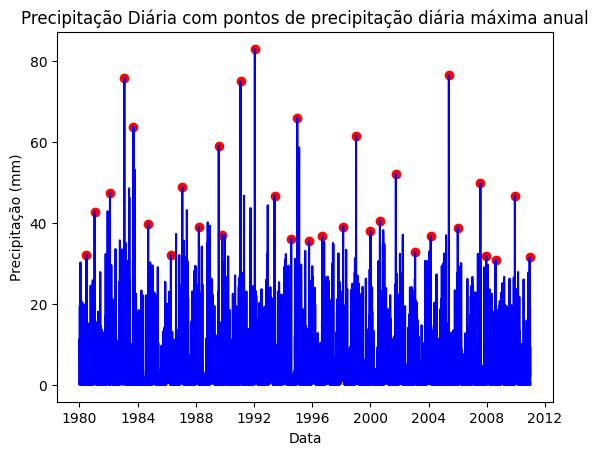

In [ ]:
# Calcular a precipitação máxima diária anual
precipitacao_max_anual = precipitacao_dados.loc[precipitacao_dados.groupby('hydro_year')['PREC'].idxmax()].reset_index()
precipitacao_max_anual = precipitacao_max_anual[['data', 'hydro_year','PREC']]
precipitacao_max_anual = precipitacao_max_anual.rename(columns={'PREC': 'Max_PREC'})
precipitacao_max_anual


#Meses do ano
#meses = ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']

#Plotagem
plt.plot(data, precipitacao_dados['PREC'], color="blue")
plt.scatter(precipitacao_max_anual['data'], precipitacao_max_anual['Max_PREC'], color="red")
plt.title('Precipitação Diária com pontos de precipitação diária máxima anual')
plt.xlabel('Data')
plt.ylabel('Precipitação (mm)')
plt.show()

## Ajustar equações de distribuição de probabilidades empíricas aplicadas aos dados observados

### Kimbal

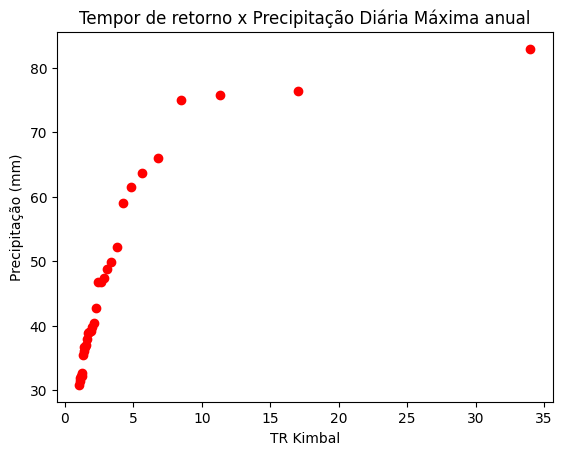

In [ ]:
precipitacao_max_anual_sort = precipitacao_max_anual.sort_values(by = "Max_PREC",ascending=False).reset_index()
precipitacao_max_anual_sort['Prob_kimbal'] = np.arange(1,len(precipitacao_max_anual_sort)+1)/(len(precipitacao_max_anual_sort)+2)
precipitacao_max_anual_sort['TR_kimbal'] = 1/precipitacao_max_anual_sort['Prob_kimbal']


plt.scatter(precipitacao_max_anual_sort['TR_kimbal'], precipitacao_max_anual_sort['Max_PREC'], color="red")
plt.title('Tempor de retorno x Precipitação Diária Máxima anual')
plt.xlabel('TR Kimbal')
plt.ylabel('Precipitação (mm)')
plt.show()

### Califórnia

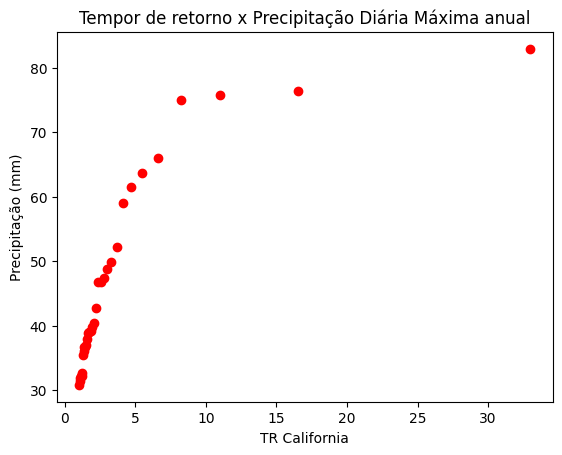

In [ ]:
precipitacao_max_anual_sort['Prob_california'] = np.arange(1,len(precipitacao_max_anual_sort)+1)/(len(precipitacao_max_anual_sort)+1)
precipitacao_max_anual_sort['TR_california'] = 1/precipitacao_max_anual_sort['Prob_california']


plt.scatter(precipitacao_max_anual_sort['TR_california'], precipitacao_max_anual_sort['Max_PREC'], color="red")
plt.title('Tempor de retorno x Precipitação Diária Máxima anual')
plt.xlabel('TR California')
plt.ylabel('Precipitação (mm)')
plt.show()

### Log-normal

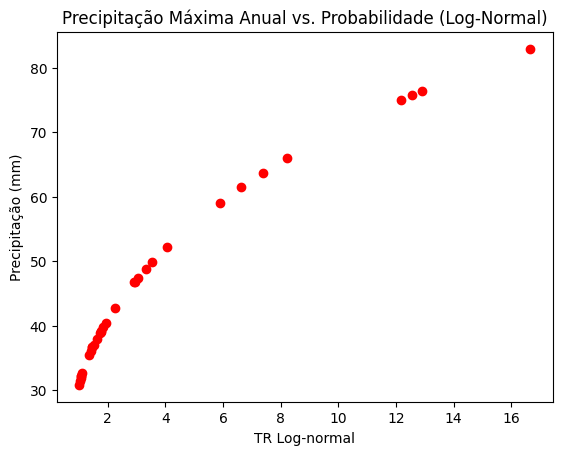

In [ ]:
# Fit a log-normal distribution to the data
from scipy.stats import lognorm

shape, loc, scale = lognorm.fit(precipitacao_max_anual_sort['Max_PREC'])

# Calculate probabilities for the fitted log-normal distribution
precipitacao_max_anual_sort['Prob_lognormal'] = 1-lognorm.cdf(precipitacao_max_anual_sort['Max_PREC'], shape, loc=loc, scale=scale)
precipitacao_max_anual_sort['TR_lognormal'] = 1/(precipitacao_max_anual_sort['Prob_lognormal'])

# Now you have the 'Prob_lognormal' column in your DataFrame.
# You can adjust 'Max_PREC' values or parameters of the lognorm.fit function if necessary to achieve the desired probabilities.

# Example: plotting the results
plt.scatter(precipitacao_max_anual_sort['TR_lognormal'], precipitacao_max_anual_sort['Max_PREC'], color="red")
plt.title('Precipitação Máxima Anual vs. Probabilidade (Log-Normal)')
plt.xlabel('TR Log-normal')
plt.ylabel('Precipitação (mm)')
plt.show()


### Gumbel

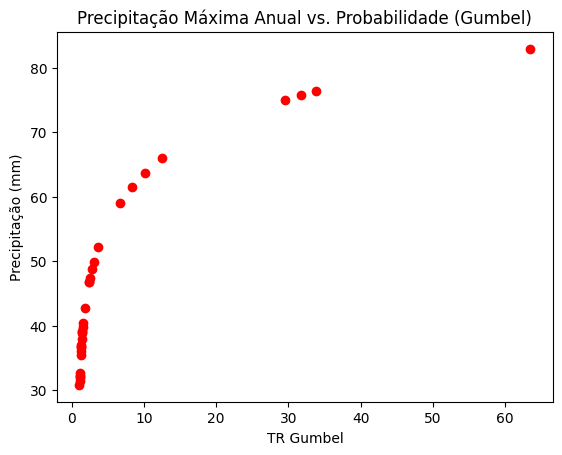

In [ ]:
# prompt: ajustar Max_PREC para log-normal para obter as probabilidades Gumbel

# Calculate Gumbel parameters
import scipy.stats as stats

# Fit the Gumbel distribution
loc, scale = stats.gumbel_r.fit(precipitacao_max_anual_sort['Max_PREC'])

# Calculate probabilities for the fitted Gumbel distribution
precipitacao_max_anual_sort['Prob_gumbel'] = 1 - stats.gumbel_r.cdf(precipitacao_max_anual_sort['Max_PREC'], loc=loc, scale=scale)
precipitacao_max_anual_sort['TR_gumbel'] = 1 / (precipitacao_max_anual_sort['Prob_gumbel'])

# Now you have the 'Prob_gumbel' column and 'TR_gumbel' in your DataFrame.

# Example: plotting the results
plt.scatter(precipitacao_max_anual_sort['TR_gumbel'], precipitacao_max_anual_sort['Max_PREC'], color="red")
plt.title('Precipitação Máxima Anual vs. Probabilidade (Gumbel)')
plt.xlabel('TR Gumbel')
plt.ylabel('Precipitação (mm)')
plt.show()


### Pearson 3

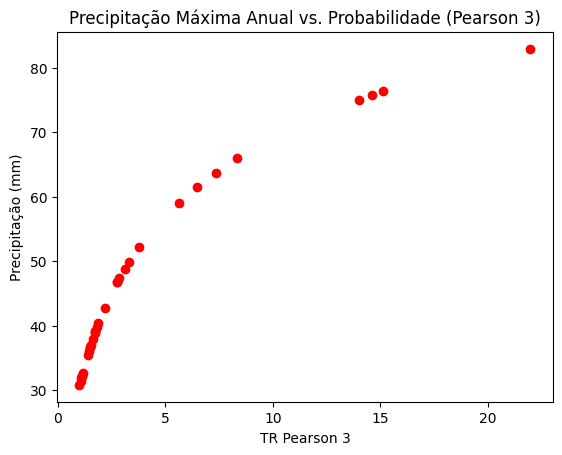

In [ ]:

# Fit the Pearson 3 distribution

skew, loc, scale = stats.pearson3.fit(precipitacao_max_anual_sort['Max_PREC'], loc=0, scale=1)


# Calculate probabilities and return periods for Pearson 3
precipitacao_max_anual_sort['Prob_pearson3'] = 1 -stats.pearson3.cdf(precipitacao_max_anual_sort['Max_PREC'], skew = skew, loc=loc, scale=scale)
precipitacao_max_anual_sort['TR_pearson3'] = 1 / ( precipitacao_max_anual_sort['Prob_pearson3'])

# Now you have 'Prob_pearson3' and 'TR_pearson3' columns in your DataFrame.

# Example: Plotting the Pearson 3 results
plt.scatter(precipitacao_max_anual_sort['TR_pearson3'], precipitacao_max_anual_sort['Max_PREC'], color="red")
plt.title('Precipitação Máxima Anual vs. Probabilidade (Pearson 3)')
plt.xlabel('TR Pearson 3')
plt.ylabel('Precipitação (mm)')
plt.show()

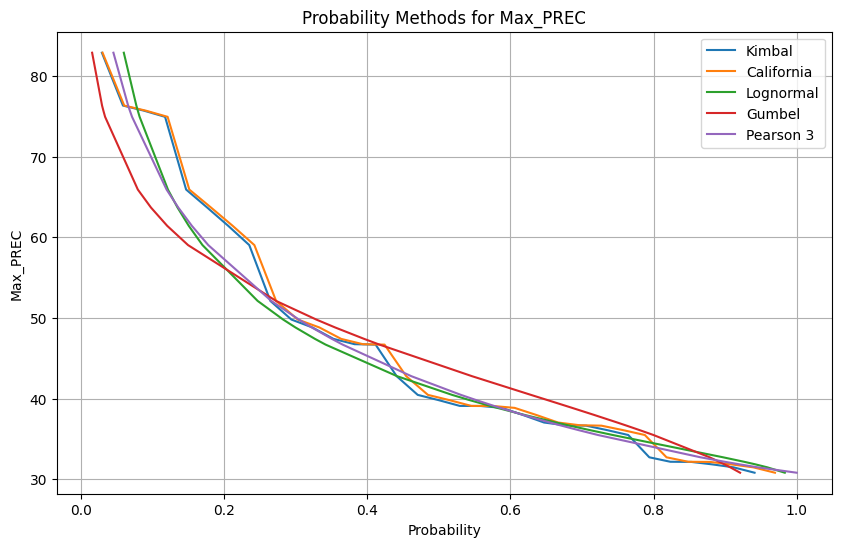

In [ ]:
# prompt: precipitacao_max_anual_sort.plot(x='Prob_kimbal', y='Max_PREC')
# precipitacao_max_anual_sort.plot(x='Prob_california', y='Max_PREC')
# precipitacao_max_anual_sort.plot(x='Prob_lognormal', y='Max_PREC')
# precipitacao_max_anual_sort.plot(x='Prob_gumbel', y='Max_PREC') adicionar todos os plots em um só com uma legenda indicando o nome do método de estimar a probabilidade

plt.figure(figsize=(10, 6))  # Adjust figure size as needed

plt.plot(precipitacao_max_anual_sort['Prob_kimbal'], precipitacao_max_anual_sort['Max_PREC'], label='Kimbal')
plt.plot(precipitacao_max_anual_sort['Prob_california'], precipitacao_max_anual_sort['Max_PREC'], label='California')
plt.plot(precipitacao_max_anual_sort['Prob_lognormal'], precipitacao_max_anual_sort['Max_PREC'], label='Lognormal')
plt.plot(precipitacao_max_anual_sort['Prob_gumbel'], precipitacao_max_anual_sort['Max_PREC'], label='Gumbel')
plt.plot(precipitacao_max_anual_sort['Prob_pearson3'], precipitacao_max_anual_sort['Max_PREC'], label='Pearson 3')

plt.xlabel('Probability')
plt.ylabel('Max_PREC')
plt.title('Probability Methods for Max_PREC')
plt.legend()
plt.grid(True)
plt.show()

## Aplicar testes de aderência estatísticos (e.g., Kolgomorov-Smirnov)

In [ ]:
t30_5 = 0.34
t30_10 = 0.54
t30_15 = 0.70
t30_20 = 0.81
t30_25 = 0.91
t1_30 = 0.74
t24_1 = 0.42
t24_6 = 0.72
t24_8 = 0.78
t24_10 = 0.82
t24_12 = 0.85
t24 = 1.14

time = [5,10,15,20,25,30,60,360,480,600,720,1440]



In [ ]:
# prompt: Aplicar os coeficientes de desgragegação da célula anterior para gerar as chuvas desagregegadas nos seguintes tempos 5,10,15,20,25,30,60,360,480,600,720,1440 min

# Coeficientes de desgragegação (exemplo - substitua pelos seus valores)
coeficientes = {
    5: t30_5,
    10: t30_10,
    15: t30_15,
    20: t30_20,
    25: t30_25,
    30: t1_30,
    60: t24_6,
    360: t24_1,
    480: t24_8,
    600: t24_10,
    720: t24_12,
    1440: t24
}

chuvas_desagregadas = {}
for t in time:
  chuvas_desagregadas[t] = precipitacao_max_anual_sort['Max_PREC'] * coeficientes[t]

# Criar um DataFrame com os resultados
df_chuvas_desagregadas = pd.DataFrame(chuvas_desagregadas)
df_chuvas_desagregadas = pd.concat([precipitacao_max_anual_sort, df_chuvas_desagregadas], axis=1)
df_chuvas_desagregadas

,index,data,hydro_year,Max_PREC,Prob_kimbal,TR_kimbal,Prob_california,TR_california,Prob_lognormal,TR_lognormal,...,15,20,25,30,60,360,480,600,720,1440
0,12,1992-01-22,1992,82.920,0.029412,34.000000,0.030303,33.000000,0.060006,16.665092,...,58.0440,67.16520,75.45720,61.36080,59.70240,34.82640,64.67760,67.99440,70.48200,94.52880
1,25,2005-05-25,2005,76.361,0.058824,17.000000,0.060606,16.500000,0.077532,12.897849,...,53.4527,61.85241,69.48851,56.50714,54.97992,32.07162,59.56158,62.61602,64.90685,87.05154
2,3,1983-02-01,1983,75.726,0.088235,11.333333,0.090909,11.000000,0.079561,12.569046,...,53.0082,61.33806,68.91066,56.03724,54.52272,31.80492,59.06628,62.09532,64.36710,86.32764
3,11,1991-01-27,1991,74.963,0.117647,8.500000,0.121212,8.250000,0.082089,12.181944,...,52.4741,60.72003,68.21633,55.47262,53.97336,31.48446,58.47114,61.46966,63.71855,85.45782
4,15,1994-12-22,1995,65.935,0.147059,6.800000,0.151515,6.600000,0.121647,8.220537,...,46.1545,53.40735,60.00085,48.79190,47.47320,27.69270,51.42930,54.06670,56.04475,75.16590
5,4,1983-09-19,1984,63.704,0.176471,5.666667,0.181818,5.500000,0.135060,7.404124,...,44.5928,51.60024,57.97064,47.14096,45.86688,26.75568,49.68912,52.23728,54.14840,72.62256
6,19,1999-01-06,1999,61.432,0.205882,4.857143,0.212121,4.714286,0.150760,6.633054,...,43.0024,49.75992,55.90312,45.45968,44.23104,25.80144,47.91696,50.37424,52.21720,70.03248
7,9,1989-07-30,1989,59.041,0.235294,4.250000,0.242424,4.125000,0.169944,5.884278,...,41.3287,47.82321,53.72731,43.69034,42.50952,24.79722,46.05198,48.41362,50.18485,67.30674
8,22,2001-10-02,2002,52.116,0.264706,3.777778,0.272727,3.666667,0.246927,4.049783,...,36.4812,42.21396,47.42556,38.56584,37.52352,21.88872,40.65048,42.73512,44.29860,59.41224
9,27,2007-07-25,2007,49.801,0.294118,3.400000,0.303030,3.300000,0.282617,3.538358,...,34.8607,40.33881,45.31891,36.85274,35.85672,20.91642,38.84478,40.83682,42.33085,56.77314


In [ ]:
# prompt: pivotar longer o df_chuvas_desagregadas para que fique uma coluna com os tempos em minutos e os valores desagregados em outra coluna

# Reshape the DataFrame using melt
df_chuvas_desagregadas = df_chuvas_desagregadas[['data','hydro_year', 'Max_PREC', 'Prob_pearson3', 'TR_pearson3']]
df_chuvas_desagregadas_long = df_chuvas_desagregadas.melt(id_vars=['data', 'hydro_year', 'Max_PREC', 'Prob_pearson3', 'TR_pearson3'],
                                                        var_name='Tempo',
                                                        value_name='PREC_DES')

df_chuvas_desagregadas_long['PREC_DES'] = df_chuvas_desagregadas_long['PREC_DES']/df_chuvas_desagregadas_long['Tempo']*60

df_chuvas_desagregadas_long

,data,hydro_year,Max_PREC,Prob_pearson3,TR_pearson3,Tempo,PREC_DES


In [ ]:
df_chuvas_desagregadas_long

,index,data,hydro_year,Max_PREC,Prob_kimbal,TR_kimbal,Tempo,PREC_DES
0,12,1992-01-22,1992,82.920,0.029412,34.000000,Prob_california,0.030303
1,25,2005-05-25,2005,76.361,0.058824,17.000000,Prob_california,0.060606
2,3,1983-02-01,1983,75.726,0.088235,11.333333,Prob_california,0.090909
3,11,1991-01-27,1991,74.963,0.117647,8.500000,Prob_california,0.121212
4,15,1994-12-22,1995,65.935,0.147059,6.800000,Prob_california,0.151515
...,...,...,...,...,...,...,...,...
635,6,1986-04-15,1986,32.149,0.823529,1.214286,1440,36.649860
636,0,1980-06-26,1980,32.128,0.852941,1.172414,1440,36.625920
637,28,2007-12-19,2008,31.821,0.882353,1.133333,1440,36.275940
638,31,2010-12-13,2011,31.459,0.911765,1.096774,1440,35.863260


In [ ]:
def idf_sherman(K,TR,a,b,tempo,c):
  i = (K*TR**a)/((b+tempo)**c)
  return(i)

# Define the IDF function
def idf_sherman(K, TR, a, b, tempo, c):
    # Using np.power to handle potential overflows
    return (K * np.power(TR, a)) / (np.power(b + tempo, c))


In [ ]:
import numpy as np
from scipy.optimize import least_squares


# Residuals function
def residuals(params, TR, tempo, i_observed):
    K, a, b, c = params
    # Convert Pandas Series to NumPy arrays
    i_calculated = idf_sherman(K, TR, a, b, tempo, c)

    return ((np.mean(np.abs(i_observed - i_calculated))))


# Prepare initial guess and bounds
params0 = [1000, 1, 10, 1]
bounds = ([0.01, 0.01, 0.01, 0.01], [10000, 5, 50, 5])

result = least_squares(residuals,
                       params0,
                       bounds= bounds,
                       args=(df_chuvas_desagregadas_long['TR'],
                             df_chuvas_desagregadas_long['Tempo'],
                             df_chuvas_desagregadas_long['PREC_DES']))
K, a, b, c = result['x']

print(result['x'])

[1.01157491e+03 1.86588135e-01 9.16946443e+00 6.69448212e-01]


In [ ]:
residuals([K, a, b, c], df_chuvas_desagregadas_long['TR'].to_numpy(),
                             df_chuvas_desagregadas_long['Tempo'].to_numpy(),
                             df_chuvas_desagregadas_long['PREC_DES'].to_numpy())

25.031737609948106

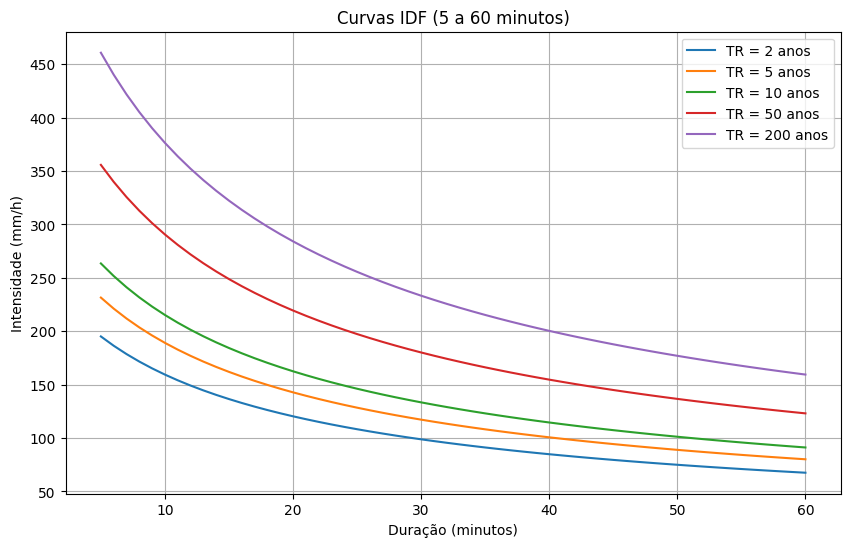

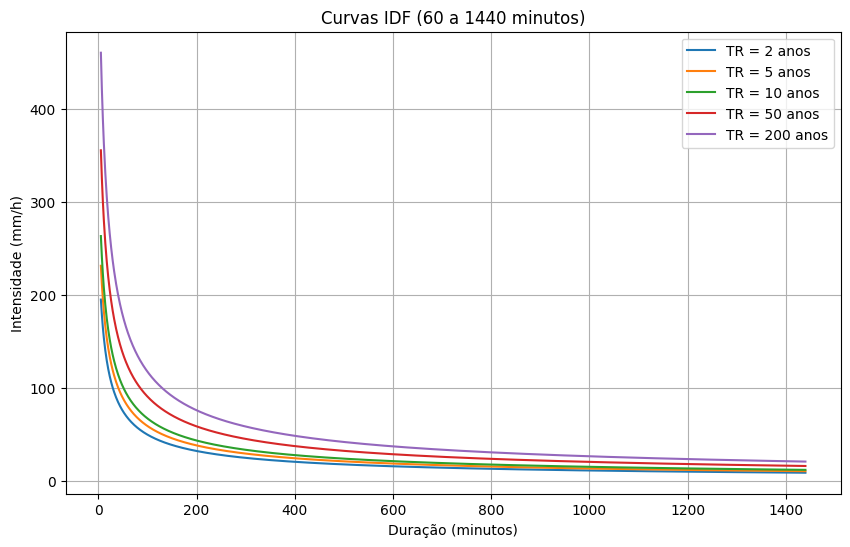

In [ ]:
# Criar um DataFrame para armazenar os resultados das curvas IDF
idf_results = pd.DataFrame()

# Tempos de retorno (TR)
trs = [2, 5, 10, 50, 200]

# Loop pelos tempos de retorno
for tr in trs:
    # Calcular as intensidades para diferentes durações de chuva
    duracoes = np.arange(5, 1441)  # Durações de 1 a 1440 minutos
    intensidades = idf_sherman(K, tr, a, b, duracoes, c)

    # Criar um DataFrame temporário com os resultados para o TR atual
    temp_df = pd.DataFrame({'Duracao': duracoes, 'Intensidade': intensidades, 'TR': tr})

    # Concatenar os resultados ao DataFrame principal
    idf_results = pd.concat([idf_results, temp_df])

# Criar o primeiro gráfico (5 a 60 minutos)
plt.figure(figsize=(10, 6))
for tr in trs:
    subset = idf_results[(idf_results['TR'] == tr) & (idf_results['Duracao'] <= 60)]
    plt.plot(subset['Duracao'], subset['Intensidade'], label=f'TR = {tr} anos')
plt.xlabel('Duração (minutos)')
plt.ylabel('Intensidade (mm/h)')
plt.title('Curvas IDF (5 a 60 minutos)')
plt.legend()
plt.grid(True)
plt.show()

# Criar o segundo gráfico (60 a 1440 minutos)
plt.figure(figsize=(10, 6))
for tr in trs:
    subset = idf_results[(idf_results['TR'] == tr) & (idf_results['Duracao'] >= 5)]
    plt.plot(subset['Duracao'], subset['Intensidade'], label=f'TR = {tr} anos')
plt.xlabel('Duração (minutos)')
plt.ylabel('Intensidade (mm/h)')
plt.title('Curvas IDF (60 a 1440 minutos)')
plt.legend()
plt.grid(True)
plt.show()